# Chest CT Scan Image Analysis

# Imports

In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

from PIL import Image, ImageFile


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Functions

In [31]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_and_preprocess_image(image_path, target_size=(250, 250)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            img = img.convert('RGB')

            img_array = np.array(img) / 255.0
            img_array = img_array.astype(np.float32)
        return img_array
    except IOError as e:

        print(f"Error loading image {image_path}: {e}")
        return None

def grab_images(directory):
    X = []
    y = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img = load_and_preprocess_image(file_path)
                if img is not None:
                    X.append(img)
                    label = root.split(os.sep)[-1]
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

def create_model(n_classes):
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax') 
])

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()
    return model

# EDA Analysis

In [19]:
PATH = "/Users/maukanmir/Downloads/Data/"
train_path, test_path, val_path = PATH + "train/", PATH + "test/", PATH + "valid/"

In [20]:
X_train, y_train = grab_images(train_path)
X_test, y_test = grab_images(test_path)
X_val, y_val = grab_images(val_path)

# Check Class Balance

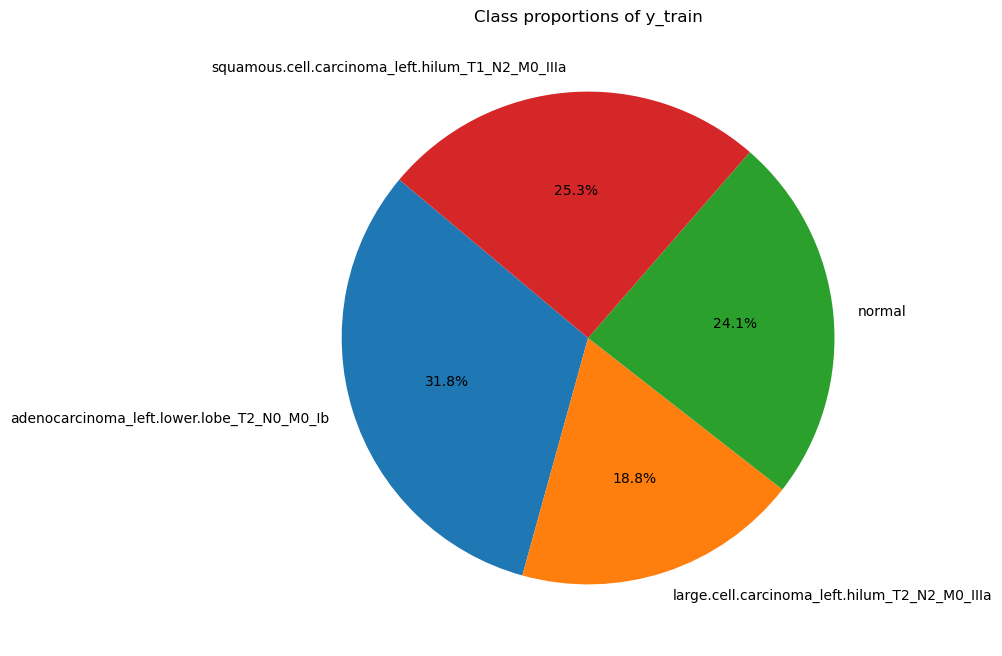

In [21]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,8))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=140)
plt.title("Class proportions of y_train")
plt.show()

# Fairly Balanced Dataset

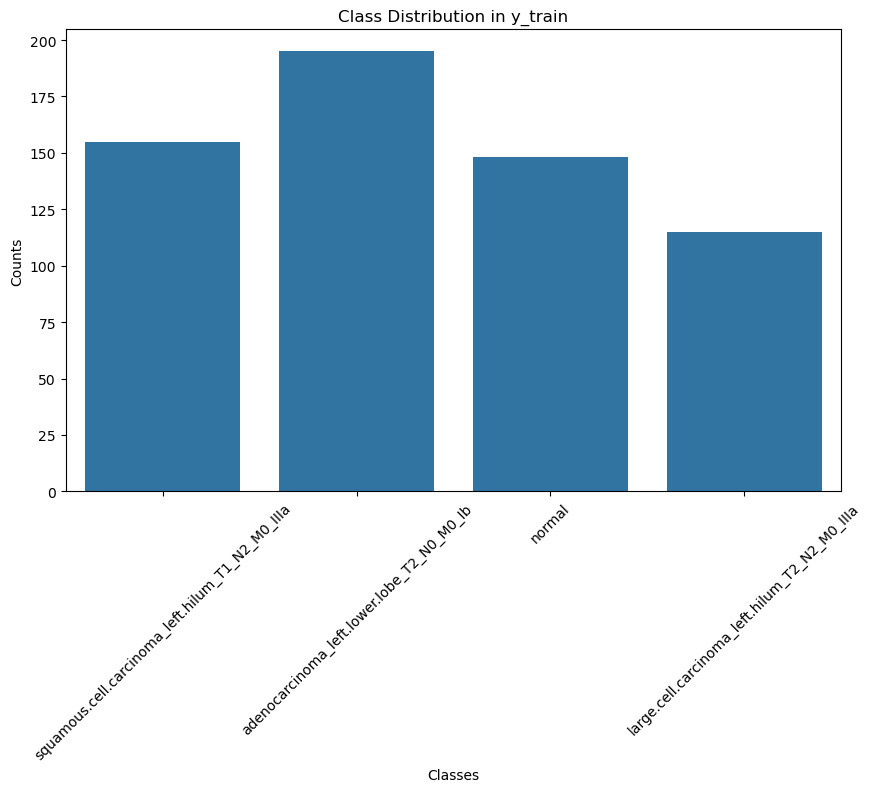

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution in y_train')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

# Data Augmentation

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.


Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# Create Model

In [32]:
model = create_model(len(unique))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 29, 29, 128)     

In [36]:
batch_size = 32
train_steps_per_epoch = math.ceil(613 / batch_size)
validation_steps = math.ceil(72 / batch_size)

In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch, 
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=0
)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(613, 250, 250, 3)
(315, 250, 250, 3)
(613,)
(315,)
(72, 250, 250, 3)
(72,)
